![VAE.png](Images\Notebook_images\VAE.png)
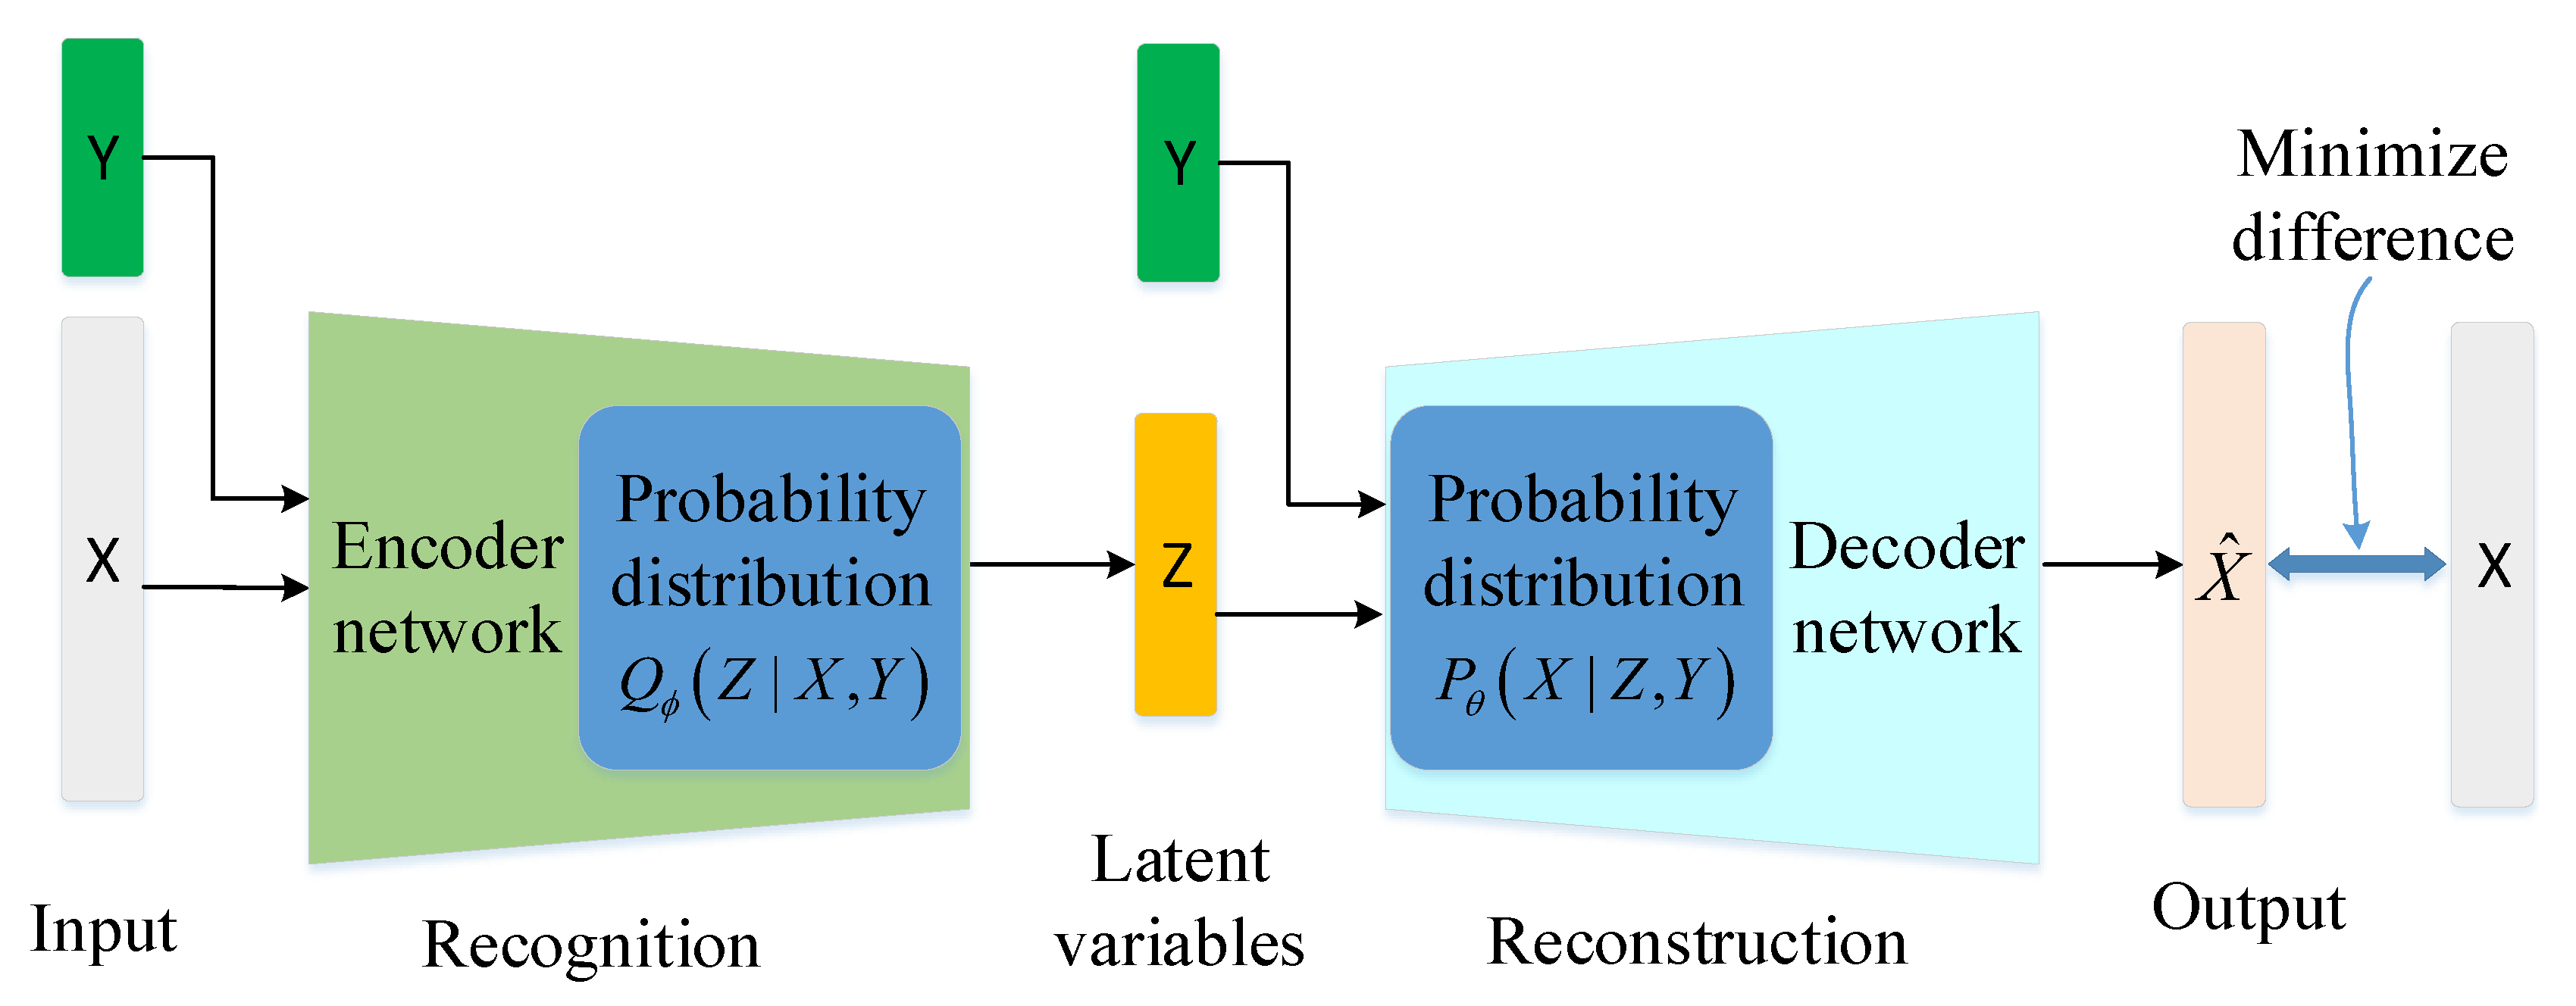

1.  [Introduction](#1)
2.  [Applications](#2)
3.  [Architecture](#3)
4.  [Properties of Autoencoder](#4)
5.  [Types of Autoencoder](#5)
6.  [Variational Autoencoder (convolutional)](#vae)
    * [Encoder implementation](#7)
    * [Latent space implementation](#8)
    * [Decoder implementation](#9)
    * [Loss Function](#10)
    * [Model layers plot](#11)
    * [Model training](#12)
    * [Model prediction](#13)
    * [Visualize  prediction](#14)
    * [Encoded dimension visualization ](#15)
    * [Decoder/Generator Model](#16)
    * [Remove Noise](#17)

# <font color='red'>Please!!! Upvote this kernel if you find it useful.</font>

<a id='1'></a>
# Autoencoder
* neural network with unsupervised machine-learning algorithm apply back-prop to set target value to the input
* auto-encoder prefers over PCA because it can learn non-linear transformations with non-linear activation functions. more efficient to learn several layer with auto-encoder then one huge transformation with PCA.

<a id='2'></a>
# Autoencoder Applications
* Image coloring (Black-white images -> colored)
* Feature variation (Extract required feature)
* Dimensionality Reduction
* Denosing image (Remove Noise)
* Remove watermark

<a id='3'></a>
# Autoencoder Architecture
* **Encoder** : part of NN compress the input into latent space representation
* **code** : part of NN represents compressed input 
* **Decoder** : Decode the encoded data to original dimension

![encoder_decoder.png](Images\Notebook_images\encoder_decoder.png)
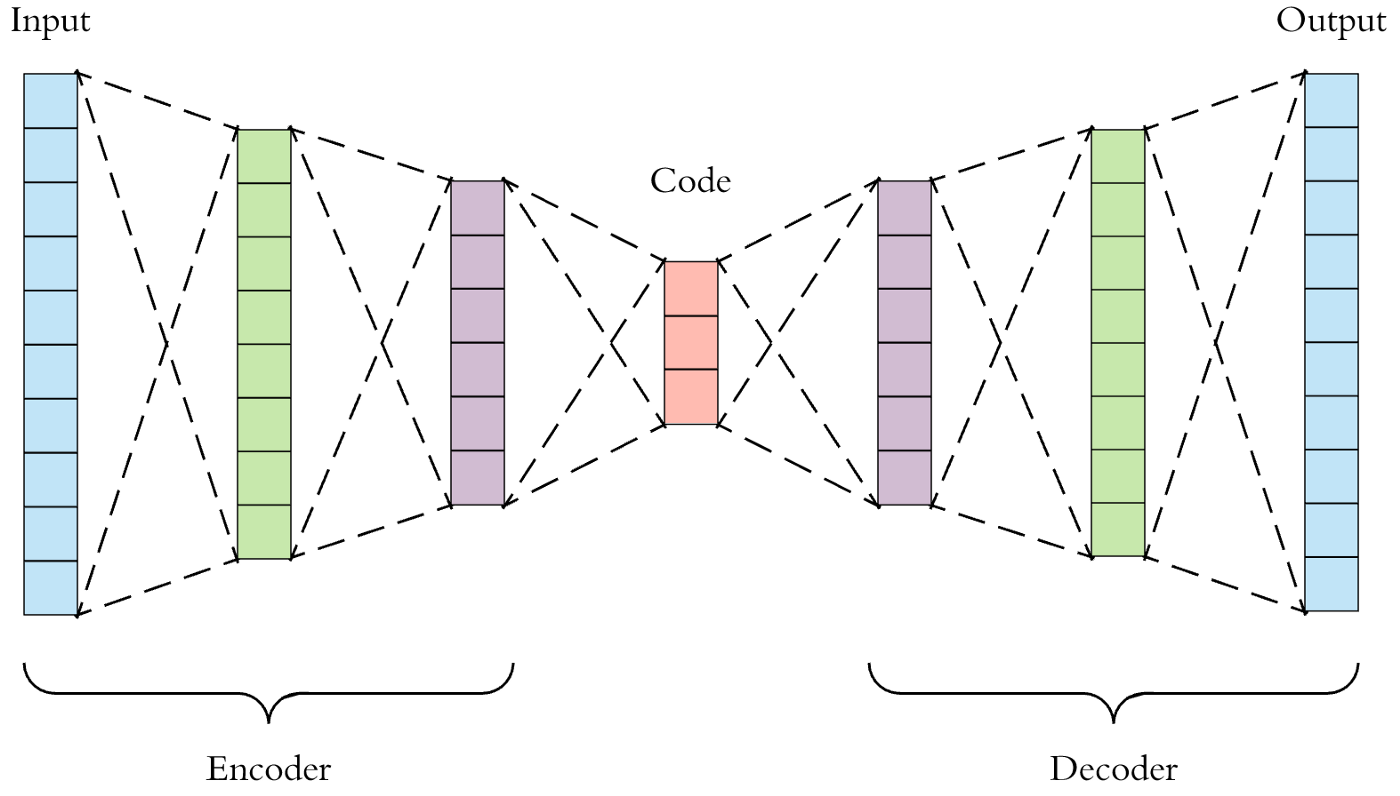

<a id='4'></a>
# Properties of Autoencoder
1. **Data-specific**: Autoencoders are only able to meaningfully compress data similar to what they have been trained on.
2. **Lossy**: de-compressed output will be degrad compared to the original input
3. **Unsupervised**: Autoencoders are considered an unsupervised learning technique since they don’t need explicit labels to train on. But to be more precise they are **self-supervised** because they generate their own labels from the training data.

<a id='5'></a>
# Types of Autoencoder
1.  **Denoising** autoencoder.
2.  **Sparse** Autoencoder.
3.  **Deep** Autoencoder.
4.  **Contractive** Autoencoder.
5.  **Undercomplete** Autoencoder.
6.  **Convolutional** Autoencoder.
7.  **Variational** Autoencoder.

# Variational Autoencoder (convolutional)<a id="vae"></a>


<a id='6'></a>
![Conv_vae.png](Images\Notebook_images\Conv_vae.png)
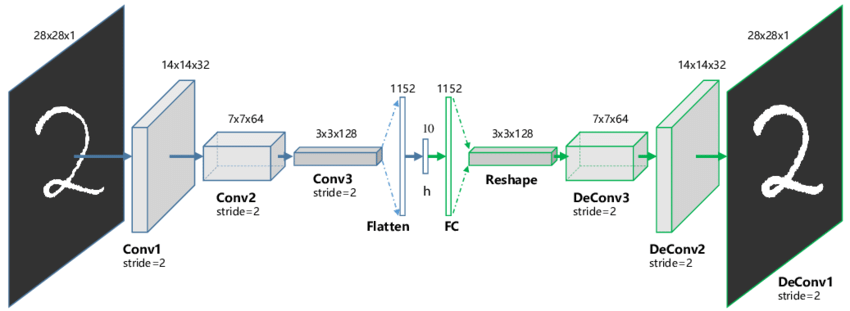

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import norm

import keras
from keras import backend as k
k.clear_session()

In [ ]:
# set parameter
image_shape = (28,28,1)
batch_size = 64
latent_dim = 10
epoch = 30

In [ ]:
# import minist dataset
(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()

In [ ]:
# change datatype and reshape data
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + image_shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + image_shape)

In [ ]:
# function to fatch 10 images of labeld 0 to 9
def get_images_1_to_10(x_train,y_train):
    selected_x,selected_y = [],[]
    for i in range(10):
        number_index = np.where(y_train == i)[0]
        random_index = np.random.choice(len(number_index),1,replace=False)
        select_index = number_index[random_index]
        selected_x.append(x_train[select_index[0]])
        selected_y.append(y_train[select_index][0])
    return np.array(selected_x,dtype="float32").reshape((len(selected_x),)+image_shape),np.array(selected_y,dtype="float32")

In [ ]:
# select random 10 image of labeled 0 to 9
selected_x,selected_y =  get_images_1_to_10(x_train,y_train)

In [ ]:
# function for plot images
def plot_image(selected_x,selected_y,title=None,save=None):
    ncols = selected_x.shape[0]
    fig,ax  = plt.subplots(nrows=1, ncols=ncols,figsize=(20,3))
    for x,y,ax_i in zip(selected_x,selected_y,ax):
        ax_i.imshow(x.reshape((28,28)))
        ax_i.axis("off")
        ax_i.set_title(int(y))
    if title:
        fig.suptitle(title)
    if save:
        fig.savefig(str(save)+".png")
    plt.show()

In [ ]:
# plot selected images
plot_image(selected_x,selected_y,title="original images",save="original_images")

<a id='7'></a>
## Encoder implementation

In [ ]:
# Input layer
# input shape = (None,28,28,1)
encoder_input = keras.Input(shape=image_shape)

# convolutional layer 1
# input shape = (None,28,28,1)
# output shape = (None,28,28,32)
conv_1 = keras.layers.Conv2D(filters=32,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(encoder_input)

# convolutional layer 2
# input shape = (None,28,28,32)
# output shape = (None,28,28,64)
conv_2 = keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(conv_1)

# convolutional layer 3
# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_3 = keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(conv_2)

# Flatten layer
# input shape = (None,28,28,64)
# output shape = (None,50176)
flatten = keras.layers.Flatten()(conv_3)

# Dense layer 1
# input shape = (None,50176)
# output shape = (None,128)
encoder_output = keras.layers.Dense(128,activation="relu")(flatten)

<a id='8'></a>
## Latent space implementation

In [ ]:
# latent mean and (log)variance

# Dense layer 2
# input shape = (None,128)
# output shape = (None,latent_dim)
z_mu = keras.layers.Dense(latent_dim)(encoder_output)

# Dense layer 3
# input shape = (None,128)
# output shape = (None,latent_dim)
z_log_sigma = keras.layers.Dense(latent_dim)(encoder_output)

In [ ]:
# sampling function for latent layer
def sampling(args):
    z_mu, z_log_sigma = args

    # epsilon is simple normal distribution
    epsilon = k.random_normal(shape=(k.shape(z_mu)[0], latent_dim),mean=0., stddev=1.)
    return z_mu + k.exp(z_log_sigma) * epsilon

z = keras.layers.Lambda(sampling,output_shape=(latent_dim,))([z_mu, z_log_sigma])

<a id='9'></a>
## Decoder implementation

In [ ]:
# Dense layer 4
# input shape = (None,latent_dim)
# output shape = (None,128)
dense_2 = keras.layers.Dense(128,activation="relu")

# Dense layer 4
# input shape = (None,128)
# output shape = (None,50176)
dense_3 = keras.layers.Dense(np.prod(k.int_shape(conv_3)[1:]),
                             activation="relu"
                            )

# Reshape layer 
# input shape = (None,128)
# output shape = (None,28,28,64)
reshape = keras.layers.Reshape(k.int_shape(conv_3)[1:])

# Deconvolutional layer 1
# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_4 = keras.layers.Conv2DTranspose(filters=64,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )
# Deconvolutional layer 2
# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_5 = keras.layers.Conv2DTranspose(filters=64,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )

# Deconvolutional layer 3
# input shape = (None,28,28,64)
# output shape = (None,28,28,32)
conv_6 = keras.layers.Conv2DTranspose(filters=32,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )

# convolutional layer 4
# input shape = (None,28,28,32)
# output shape = (None,28,28,1)
decoder_output = keras.layers.Conv2D(filters=1,
                                     kernel_size=3,
                                     padding="same",
                                     activation="sigmoid"
                                    )

_dense_2 = dense_2(z)
_dense_3 = dense_3(_dense_2)
_reshape = reshape(_dense_3)
_conv_4 = conv_4(_reshape)
_conv_5 = conv_5(_conv_4)
_conv_6 = conv_6(_conv_5)
_decoder_output = decoder_output(_conv_6)

## Loss Function<a id='10'></a>

In [ ]:
def vae_loss(x, z_decoded):
        x = k.flatten(x)
        z_decoded = k.flatten(z_decoded)
        # Reconstruction loss
        Reconstruction_loss = 786*keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -0.5 * k.mean(1 + z_log_sigma - k.square(z_mu) - k.exp(z_log_sigma), axis=-1)
        return Reconstruction_loss + kl_loss

## Model compile and summary

In [ ]:
variational_encoder = keras.Model(encoder_input,_decoder_output)
variational_encoder.compile(optimizer='rmsprop',loss=vae_loss)
variational_encoder.summary()

## Model plot<a id='11'></a>

In [ ]:
keras.utils.plot_model(variational_encoder,to_file="variational_encoder_L{}_E_{}.png".format(latent_dim,epoch),show_shapes=True)

## Model training<a id='12'></a>

In [ ]:
variational_encoder.fit(x=x_train,y=x_train,
                        shuffle=True,
                        epochs=epoch,
                        batch_size=batch_size,
                        validation_data=(x_test,x_test))

In [ ]:
# Model weights save
variational_encoder.save_weights('vae_L2_E10.h5')

## Model prediction<a id='13'></a>

In [ ]:
pred = variational_encoder.predict(selected_x)

## Visualize prediction<a id='14'></a>

In [ ]:
plot_image(selected_x,selected_y)
plot_image(pred,selected_y,title="prediction_from_original_images",save="prediction_from_original_images")

## Encoded dimension visualization <a id='15'></a>

In [ ]:
encoder = keras.Model(encoder_input,z_mu)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.title("Encoded_dimension_visualization_L{}_E{}".format(latent_dim,epoch))
plt.savefig("Encoded_dimension_visualization_L{}_E{}.png".format(latent_dim,epoch))
plt.show()

## Decoder/Generator Model<a id='16'></a>

In [ ]:
# Generator Model
decoder_input = keras.layers.Input(shape=(latent_dim,))
_dense_2 = dense_2(decoder_input)
_dense_3 = dense_3(_dense_2)
_reshape = reshape(_dense_3)
_conv_4 = conv_4(_reshape)
_conv_5 = conv_5(_conv_4)
_conv_6 = conv_6(_conv_5)
_decoder_output = decoder_output(_conv_6)

decoder = keras.Model(decoder_input,_decoder_output)

In [ ]:
digit_size = 28
n = 10  # figure with 10x10 digits
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
    for j in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = decoder.predict(z_sample, batch_size=1)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        x = i * digit_size
        y = j * digit_size
        figure[x:x + digit_size, y:y + digit_size] = digit

plt.figure(figsize=(14, 14))
plt.axis("off")
plt.imshow(figure, cmap='Greys_r')
plt.title("generated_images_L{}_E_{}".format(latent_dim,epoch))
plt.savefig("generated_images_L{}_E_{}.png".format(latent_dim,epoch))
plt.show()

# Remove Noise<a id="17"></a>

In [ ]:
def add_noise(x, noise_factor=0.1):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x

In [ ]:
selected_x_noisy = add_noise(selected_x)
pred_noise_remove = variational_encoder.predict(selected_x_noisy)

In [ ]:
# selected original images
plot_image(selected_x,selected_y,title="selected original images")
# add noise to  original images
plot_image(selected_x_noisy,selected_y,title="Noisy_images",save="Noisy_images")
# predicted images from noisy image
plot_image(pred_noise_remove,selected_y,title="prediction_from_noisy_image",save="prediction_from_noisy_image")

# <font color='red'>Please!!! Upvote this kernel if you find it useful.</font>